In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Introduction

In this project, we will attempt to greate a Generative Adversarial Network (GAN) in order to manipulate facial expressions.

Our first step is to load the neccessary libraries we will be using for the entire process.

In [2]:
#Loading the neccessary libraries
from __future__ import print_function
%matplotlib inline
from IPython.display import HTML

import os
import cv2
import glob
import numpy as np
import pandas as pd
import argparse

import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transform
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, utils

from skimage import io
from pathlib import Path
from PIL import Image


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.animation as animation
import warnings
warnings.filterwarnings('ignore')

We will now create a variable which points to our local directory. We create these variables as shortcut so we will not have to type the entire directory everytime needed. Take note that the image dataset/directory is located in a different folder than the python notebook files.

In [3]:
windows_path = '''E:\Data_Cloud\GoogleDrive\Dataset'''
colab_path = 'drive/My Drive/Dataset/'
basepath = colab_path

In [4]:
#Create Folder Paths to shorten directory
landmark = Path(os.path.join(basepath, 'Landmark'))
wild = Path(os.path.join(basepath, 'wild'))
crop_utkface = Path(os.path.join(basepath, 'Crop' ,'UTKFace'))

There are two landmark directories with 3 files in them and an image folder with two subdirectories namely crop_part1 and the UTKFace directory. In this next section, we will attempt to view the files. The landmark folders will be assigned to a dataframe and the images folder will be set up to view what some of the images may appear to be.

In [5]:
#Creating a dataframe for each of the landmark text files.
landmark1 = pd.read_csv(landmark/'landmark_list_part1.txt',header=None)
landmark2 = pd.read_csv(landmark/'landmark_list_part2.txt', header=None)
landmark3 = pd.read_csv(landmark/'landmark_list_part3.txt',header=None)

#Merging the 3 dataframes into one.
landmark_frame = pd.concat([landmark1, landmark2, landmark3])

With the second directory containing landmark files as well, we will also create a separate dataframe for each files, then merge them into one dataframe.

In [6]:
#Creating 3 dataframs for each of the files.
wild1 = pd.read_csv(wild/'landmark_list_part1.txt',header=None)
wild2 = pd.read_csv(wild/'landmark_list_part2.txt',header=None)
wild3 = pd.read_csv(wild/'landmark_list_part3.txt',header=None)

#Merging the three dataframes into one.
wild_frame = pd.concat([wild1, wild2, wild3])

### Exploring the Images in the Data Folder

Next, we will attempt to view what the images looks like in each of the two image folders. In the initial folder, crop_part1, we will pull 5 random images and observe how they appear.

In [41]:
import glob as glob

In [45]:
filename = pd.DataFrame(glob.glob(os.path.join(UTKFace_folder, '*.jpg')))

In [48]:
filename.iloc[:,0].str.find(r'\d+_0_[0-4]+_\d+.jpg.chip.jpg$')

0    -1
1    -1
2    -1
3    -1
4    -1
5    -1
6    -1
7    -1
8    -1
9    -1
10   -1
11   -1
12   -1
13   -1
14   -1
15   -1
16   -1
17   -1
18   -1
19   -1
20   -1
21   -1
22   -1
23   -1
24   -1
25   -1
26   -1
Name: 0, dtype: int64

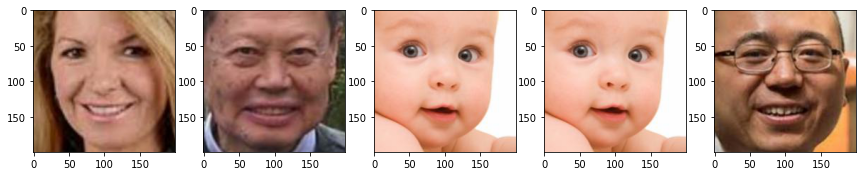

In [7]:
plt.figure(figsize=(30,30))

UTKFace_folder = '/content/drive/My Drive/Dataset/Crop/UTKFace'

for i in range(5):
    file = np.random.choice(os.listdir(UTKFace_folder))
    image_path= os.path.join(UTKFace_folder, file)
    image=mpimg.imread(image_path)
    plt.subplot(1,10,i+1)
    plt.imshow(image)

We will attempt the same procedure, but this time on a single image. We will look closely at just a single random image.

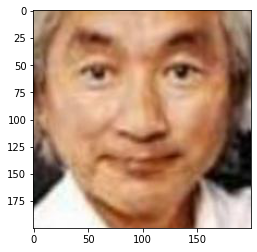

In [8]:
for i in range(1):
    file = np.random.choice(os.listdir(UTKFace_folder))
    image_path = os.path.join(UTKFace_folder, file)
    image=mpimg.imread(image_path)
    plt.imshow(image)

In [9]:
trans = transforms.Compose([
    transforms.Resize(200,200),
    transform.RandomResizedCrop([200,200]),
    transform.RandomCrop((200,200)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]) 

### Creation of a Python class

We will not create a class in order to pull images from the dataset. Unlike the previous precedures, we will not only view the dataset, but assign a class which we may use several times throughout. This class shall make it easier to load images and will be useful when creating the model at a later point.

In [11]:
#Creata a class to pull items from the image folder
class FaceDataset(Dataset):
    def __init__(self, MainFolder, transform=trans):
        self.MainFolder = MainFolder
        images = os.listdir(MainFolder)
        self.all_images = glob.glob(os.path.join(MainFolder, '*.jpg'))
        self.transform=transform
        
    def __len__(self):
        return len(self.all_images)
    
    def __getitem__(self, index):
        img_loc = self.all_images[index]
        image = io.imread(img_loc)
        if self.transform is not None:
            image=Image.fromarray(image.astype('uint8'), 'RGB')
            image=self.transform(image)
        return image

#### Create a Dataloader

In [12]:
#Creating a variable with the class and the UTKFace Folder
facedata_UTKFace = FaceDataset(UTKFace_folder)
print('There are {} images in the UTKFace folder'.format(len(facedata_UTKFace)))

There are 27 images in the UTKFace folder


In [13]:
dataloader = DataLoader(facedata_UTKFace, batch_size=64, shuffle=True, sampler=None,
                            batch_sampler=None, num_workers=2, collate_fn=None,
                            pin_memory=False, drop_last=False, timeout=0, worker_init_fn=None)

##### Transformation for Evaluation

In [14]:
eval_trans = transforms.Compose([
        transforms.Resize(200, 200),
        #transform.RandomResizedCrop([200,200]),
        #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        transforms.ToTensor(),
        ]) 

In [15]:
facedata_UTKFace.MainFolder

'/content/drive/My Drive/Dataset/Crop/UTKFace'

In [16]:
facedata_UTKFace[17]

tensor([[[ 0.2863,  0.3176,  0.3490,  ..., -0.3490, -0.3882, -0.4196],
         [ 0.2863,  0.3176,  0.3490,  ..., -0.3569, -0.3882, -0.4196],
         [ 0.2863,  0.3176,  0.3412,  ..., -0.3490, -0.3804, -0.4118],
         ...,
         [ 0.2392,  0.2784,  0.3098,  ..., -0.0118,  0.0039,  0.0118],
         [ 0.2392,  0.2706,  0.3020,  ..., -0.0118,  0.0039,  0.0118],
         [ 0.2314,  0.2706,  0.3020,  ..., -0.0196, -0.0039,  0.0039]],

        [[ 0.0588,  0.0824,  0.1059,  ..., -0.5137, -0.5529, -0.5843],
         [ 0.0588,  0.0824,  0.1059,  ..., -0.5216, -0.5529, -0.5843],
         [ 0.0588,  0.0745,  0.0980,  ..., -0.5216, -0.5529, -0.5843],
         ...,
         [-0.0902, -0.0588, -0.0353,  ..., -0.2078, -0.1922, -0.1843],
         [-0.0902, -0.0667, -0.0431,  ..., -0.2078, -0.1922, -0.1843],
         [-0.0980, -0.0667, -0.0431,  ..., -0.2157, -0.2000, -0.1922]],

        [[-0.1922, -0.1608, -0.1373,  ..., -0.7255, -0.7647, -0.7961],
         [-0.1922, -0.1608, -0.1373,  ..., -0

In [17]:
# #retreiving an specific image for observations. Image number 3997
# plt.imshow(facedata_UTKFace[3997])
# plt.show()

### Analysis of Image Data

We will now further analyze the image data by looking at its raw data. Using the image 1072 of the crop folder, we display the data as a numpy array.

We will also look into the shape of some sample images, the image properties of the first image shown above are as follows. 200 width, 200 height and 3 channels (RGB).

In [18]:
print('The Size of the image is: {}'.format(facedata_UTKFace[13].size))
print('The Channel of the image is: {}'.format(facedata_UTKFace[13].shape))
print('The data type of the image is: {}'.format(type(facedata_UTKFace[13])))

The Size of the image is: <built-in method size of Tensor object at 0x7f78778d8e58>
The Channel of the image is: torch.Size([3, 200, 200])
The data type of the image is: <class 'torch.Tensor'>


#### Initilizing the GPU

Will now initialize the device to be using the GPU for quicker training.

In [19]:
#Checking if the correct gpu drivers have been installed
torch.cuda.is_available()

True

In [20]:
#Setting the device to GPU on availability
device = torch.device('cuda:0' if (torch.cuda.is_available())
                                   else 'cpu')
ngpu = 1 if torch.cuda.is_available() else 0

In [21]:
print(device, ngpu)

cuda:0 1


In [22]:
#### Noise Generartion for Vector
noise = torch.randn(128, 100, 1, 1, device=device)

#### Creating Global Variables

We will now assign some global variables which we will be using throughout our model

In [23]:
#Creating Labels
real_label = 1.
fake_label = 0.

#Batch size
batch_size = 128

#number of channels 
nc = 3

#Z latent space / vector
nz = 64

#Generator feature maps
ngf = 64

#Discriminator feature maps
ndf = 64

#beta for optimizer
beta1 = .5

#### Create custom weights



In [24]:
# def weights(m):
#     classname = m.__class__.__name__
#     if classname.find('Conv') != -1:
#         nn.init.normal_(m.weight.data, 0.0, 0.02)
#     elif classname.find('BatchNorm') != -1:
#         nn.init.normal_(m.weight.data, 1.0, 0.02)
#         nn.init.constant_(m.bias.data, 0)

In [25]:
def weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

#### Greate the Generator

In [26]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [27]:
# Create the generator
netG = Generator(ngpu).to(device)
netG.apply(weights)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(64, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


#### Create the Discriminiator

In [28]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [29]:
netD = Discriminator(ngpu).to(device)   
netD.apply(weights)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


#### Creating an optimizers

In [30]:
criterion = nn.BCELoss()
noise_f = torch.rand(64, 64, 1, 1, device=None)

In [31]:
generator = Generator(ngpu)
discriminator = Discriminator(ngpu)

optimizer_gen = torch.optim.Adam(generator.parameters(), lr=.0001, betas=(.5,.999))
optimizer_disc = torch.optim.Adam(discriminator.parameters(), lr=.0001, betas=(.5,.999))

#### Training Loop

In [32]:
iters = 0
image_list = []
Generator_loss = []
Discriminator_loss = []
num_epochs = 5

In [33]:
one_batch = next(iter(dataloader))
one_batch.shape

torch.Size([27, 3, 200, 200])

In [39]:
print('Starting the Training Loop...')


#enumerate through each epoch
for epoch in range(num_epochs):
    
    #for each batch of 128 from the dataloader
    for i, data in enumerate(dataloader, 0):
    
        ### Update Discriminator on real and fake labels ###
        
        netD.zero_grad()
        
        data = data.reshape(-1,3,200,200).float()
        #data = data.float()
        
        print(data[0].shape)

        #Formatting for each batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        
        # Forward pass batch to 0
        print(real_cpu.shape)
        output = netD(real_cpu).view(-1)
        
        print(output.shape)
        print(label.shape)
        
        print(output[0])

        #Calculate loss of real batch
        errD_real = criterion(output, label)
        
        #Calculate Gradients for 0, backward pass
        errD_real.backward()
        D_x = output.mean().item()
        
        #Fake batch training
        #Generate Batch
        noise = torch.randn(b_size, nz, 1,1, device=device)
        #Image batch with Generator
        fake = netG(noise)
        label.fill_(fake_label)
        #Classify fake batches
        output = netD(fake.detach()).view(-1)
        #Calculate loss on fake batch
        errD_fake = criterion(output, label)
        #Calculate Gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        #Add gradients from real and fake batchs
        errD = errD_real + errD_fake
        #Update Discriminator
        optimizer_disc.step()
        
        ### Update Generator on real labels###
                
        netG.zero_grad()
        label.fill_(real_label)
        #After update, perform another 0 pass
        output = netD(fake).view(-1)
        #Calculate Generator Loss
        errG = criterion(output, label)
        #Calculate Generator Gradients
        errG.backward()
        D_G_z2 = output.mean().item()
        #Update the Generator
        optimizer_gen.step()
        
        #Training stats
        if i % 1000 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f' 
              % (epoch, num_epochs, i, len(dataloader), 
                 errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        #save losses
        Generator_loss.append(errG.item())
        Discriminator_loss.append(errD.item())
        
        #Check how the generator is by saving to noise vector
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            
            with torch.no_grad():
                fake = netG(noise_f).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
    

Starting the Training Loop...
torch.Size([3, 200, 200])
torch.Size([3, 200, 200])


RuntimeError: ignored

In [ ]:
# plt.figure(figsize=(20,10))
# plt.plot(Discriminator_loss, label='D')
# plt.plot(Generator_loss, label='G')
# plt.xlabel('Number of Iterations')
# plt.ylabel('Number of Loss')
# plt.title('Plotting loss during training')
# plt.show()

In [ ]:
# fig = plt.figure(figsize=(10,10))
# ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in image_list]
# ani = animation.ArtistAnimation(fig, ims, interval = 1000, repeat_delay=1000, blit=True)
        
# HTML(ani.to_jshtml())

In [ ]:
torchvision.__version__